In [1]:
# pip install awswrangler

In [2]:
# pip install spacy

In [3]:
# pip install spacy && python -m spacy download pt_core_news_sm

In [4]:
import re
import os
import sys
import spacy
import random
import numpy as np
import pandas as pd
import awswrangler as wr
from spacy.training import Example
from spacy.util import minibatch, compounding

sys.path.append(os.path.dirname(os.getcwd())+'/src')
from preprocess import preprocess_module

---

### Reading processed data for training

In [5]:
bucket = 'ons-ds-dev-entityrecognition'
path = 'mpo/mvp/data/train/dataset.parquet'
train_dataset = wr.s3.read_parquet(f's3://{bucket}/{path}') #pd.read_parquet(os.path.dirname(os.getcwd())+'/data/dataset_0.parquet')
train_dataset.sort_values(by=['text','start', 'end'], inplace=True)

In [6]:
train_dataset[['start','end']] = train_dataset[['start','end']].astype('int')

In [7]:
train_dataset.head()

,text,entity,label,start,end
7852,1 . Desenergização ( Ambos os Sentidos ) Pass...,Verificar a necessidade de adequações,ACAO_MANUAL,156,193
7853,1 . Desenergização ( Ambos os Sentidos ) Pass...,limitações impostas pela indisponibilidade,ACAO_MANUAL,227,269
10724,1 . Desenergização ( Ambos os Sentidos ) Pass...,indisponibilidade,ESTADO_OPERATIVO,252,269
0,1 . Desenergização ( Ambos os Sentidos ) Pass...,autotransformador 500 / 230 kV,EQUIPAMENTO,273,304
1,1 . Desenergização ( Ambos os Sentidos ) Pass...,transformador 500 / 230 kV,EQUIPAMENTO,277,304


In [8]:
# train_dataset[train_dataset['text']==train_dataset['text'].iloc[0]]

---

### Feature Engineering

In [9]:
training_set = []
unique_text = sorted(set(train_dataset['text']))
for samp in unique_text:
    df_loop = train_dataset[train_dataset['text']==samp]
    df_loop.drop_duplicates(inplace=True)
    df_loop.sort_values(by=['start','end'], axis=0, ascending=True, inplace=True)
    sliding_ref = -1
    ent_list = []
    for index, row in df_loop.iterrows():
        if row['start'] > sliding_ref:
            ent_list.append([row['start'], row['end'], row['label']])
            sliding_ref = row['end']
    training_set.append([samp, {'entities': tuple(ent_list)}])

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
training_set[0]

[' 1 . Desenergização ( Ambos os Sentidos ) Passo SENTIDOS ) PassoCoordenaçãoControleComando e ExecuçãoProcedimento Item de Controle / Objetivo 1 – COSR-NE – Verificar a necessidade de adequações no sistema , para atendimento às limitações impostas pela indisponibilidade do autotransformador 500 / 230 kV – 300 MVA – T1 da SE Boa Esperança . Conforme definido na IO-OC . NE . 2OE . 2COSR-NECOSR-NEChesf ( Cron ) Desenergizar o autotransformador 500 / 230 kV – 300 MVA – T1 da SE Boa Esperança . No mínimo 02 ( duas ) unidades geradoras na UHE Boa Esperança com folga de 40 a + 20 Mvar . Fluxo de potência reativa no autotransformador 05T1 entre ( - ) 60 a + 65 Mvar . Convenção de sinais :( + ) Fluxo do 230 kV para o 500 kV .( - ) Fluxo do 500 kV para o 230 kV . ',
 {'entities': ([156, 193, 'ACAO_MANUAL'],
   [227, 269, 'ACAO_MANUAL'],
   [273, 304, 'EQUIPAMENTO'],
   [322, 338, 'SUBESTACAO'],
   [411, 426, 'ACAO_MANUAL'],
   [430, 457, 'EQUIPAMENTO'],
   [475, 491, 'SUBESTACAO'],
   [494, 503

In [11]:
train_dataset[train_dataset['text']==train_dataset['text'].iloc[0]]

,text,entity,label,start,end
7852,1 . Desenergização ( Ambos os Sentidos ) Pass...,Verificar a necessidade de adequações,ACAO_MANUAL,156,193
7853,1 . Desenergização ( Ambos os Sentidos ) Pass...,limitações impostas pela indisponibilidade,ACAO_MANUAL,227,269
10724,1 . Desenergização ( Ambos os Sentidos ) Pass...,indisponibilidade,ESTADO_OPERATIVO,252,269
0,1 . Desenergização ( Ambos os Sentidos ) Pass...,autotransformador 500 / 230 kV,EQUIPAMENTO,273,304
1,1 . Desenergização ( Ambos os Sentidos ) Pass...,transformador 500 / 230 kV,EQUIPAMENTO,277,304
18532,1 . Desenergização ( Ambos os Sentidos ) Pass...,500 / 230 kV,VALOR_COM_UNID.MEDIDA,291,303
18533,1 . Desenergização ( Ambos os Sentidos ) Pass...,230 kV,VALOR_COM_UNID.MEDIDA,297,303
13015,1 . Desenergização ( Ambos os Sentidos ) Pass...,SE Boa Esperança,SUBESTACAO,322,338
7854,1 . Desenergização ( Ambos os Sentidos ) Pass...,Desenergizar o,ACAO_MANUAL,411,426
7855,1 . Desenergização ( Ambos os Sentidos ) Pass...,energizar o autotransformador,ACAO_MANUAL,414,444


---

### Model initialization

In [12]:
nlp = spacy.blank("pt")

In [13]:
# loading spacy pt-br dependencies - training with preset
#nlp = spacy.load("pt_core_news_sm")
optimizer = nlp.create_optimizer()

# alternative - start blank model
# nlp = spacy.blank('pt')
# optimizer = nlp.begin_training()

# if NER not in pipeline modules within spacy, download it
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# printing pipelines
nlp.pipe_names

['ner']

### Adding custom labels to blank spacy model

In [14]:
# adding labels to spacy NER module
for label in set(train_dataset['label'].to_list()):
    ner.add_label(label)

#spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)
ner.labels

('ACAO_MANUAL',
 'EQUIPAMENTO',
 'ESTADO_OPERATIVO',
 'OPERADOR_MATEMATICO',
 'SUBESTACAO',
 'USINA',
 'VALOR_COM_UNID.MEDIDA')

In [15]:
import warnings
warnings.simplefilter("ignore")
n_iterations = 50
batch_size = 50
loss_list = []
pipes_except_ner = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
nlp.begin_training()

# only training NER module - no other module can be retrained in this section
with nlp.disable_pipes(*pipes_except_ner):
    for it in range(n_iterations):
        random.shuffle(training_set)
        losses = {}       
        batches = minibatch(
            training_set,
            size=batch_size
            )
        for batch in batches:
            texts, annotations = zip(*batch)
            for text, annot in zip(texts, annotations):
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annot)
                #spacy.training.offsets_to_biluo_tags(doc, annot['entities'])
                nlp.update(
                    [example],
                    sgd=optimizer, 
                    drop=0.40, 
                    losses=losses
                    )
        print('iterations: ', it+1, 'Loss: ', losses)
        loss_list.append(losses['ner'])

iterations:  1 Loss:  {'ner': 30407.91278866317}
iterations:  2 Loss:  {'ner': 9542.5380875631}
iterations:  3 Loss:  {'ner': 7261.575115177901}
iterations:  4 Loss:  {'ner': 5671.95479581815}
iterations:  5 Loss:  {'ner': 4975.4427112357125}
iterations:  6 Loss:  {'ner': 4802.211716000203}
iterations:  7 Loss:  {'ner': 4189.716111957512}
iterations:  8 Loss:  {'ner': 3978.610033847744}
iterations:  9 Loss:  {'ner': 3893.296718863487}
iterations:  10 Loss:  {'ner': 3680.7736936356914}
iterations:  11 Loss:  {'ner': 3510.874103191479}
iterations:  12 Loss:  {'ner': 3479.687814284423}
iterations:  13 Loss:  {'ner': 3479.813964448656}
iterations:  14 Loss:  {'ner': 3265.17841944546}
iterations:  15 Loss:  {'ner': 3191.4672391426266}
iterations:  16 Loss:  {'ner': 3121.782839447012}
iterations:  17 Loss:  {'ner': 3115.4834939969383}
iterations:  18 Loss:  {'ner': 3002.6209555340324}
iterations:  19 Loss:  {'ner': 2866.9176169669176}
iterations:  20 Loss:  {'ner': 2949.4945238154705}
iterat

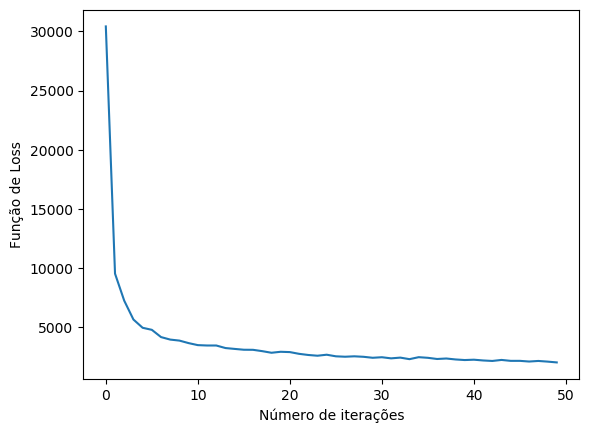

In [16]:
# loss plot
import matplotlib.pyplot as plt
plt.plot(range(n_iterations), loss_list)
plt.xlabel('Número de iterações')
plt.ylabel('Função de Loss')
plt.show()

In [20]:
# running entity recognition in dataset
recognition_dict = {
    'entity':[],
    'type':[]
}

text = train_dataset['text'].iloc[1]
print(text)
doc = nlp(text)
for i in range(len(doc.ents)):
    recognition_dict['entity'].append(str(doc.ents[i]))
    recognition_dict['type'].append(doc.ents[i].label_)
    
pd.DataFrame(recognition_dict)

 1 . Desenergização ( Ambos os Sentidos ) Passo SENTIDOS ) PassoCoordenaçãoControleComando e ExecuçãoProcedimento Item de Controle / Objetivo 1 – COSR-NE – Verificar a necessidade de adequações no sistema , para atendimento às limitações impostas pela indisponibilidade do autotransformador 500 / 230 kV – 300 MVA – T1 da SE Boa Esperança . Conforme definido na IO-OC . NE . 2OE . 2COSR-NECOSR-NEChesf ( Cron ) Desenergizar o autotransformador 500 / 230 kV – 300 MVA – T1 da SE Boa Esperança . No mínimo 02 ( duas ) unidades geradoras na UHE Boa Esperança com folga de 40 a + 20 Mvar . Fluxo de potência reativa no autotransformador 05T1 entre ( - ) 60 a + 65 Mvar . Convenção de sinais :( + ) Fluxo do 230 kV para o 500 kV .( - ) Fluxo do 500 kV para o 230 kV . 


,entity,type
0,Verificar a necessidade de adequações,ACAO_MANUAL
1,500 / 230 kV,VALOR_COM_UNID.MEDIDA
2,SE Boa Esperança,SUBESTACAO
3,Desenergizar o,ACAO_MANUAL
4,500 / 230 kV,VALOR_COM_UNID.MEDIDA
5,SE Boa Esperança,SUBESTACAO
6,No mínimo,OPERADOR_MATEMATICO
7,UHE Boa Esperança com,USINA
8,20 Mvar,VALOR_COM_UNID.MEDIDA
9,entre,OPERADOR_MATEMATICO


In [21]:
nlp.to_disk('../artifacts/model')

### Metrics

In [22]:
from spacy.scorer import Scorer

In [23]:
examples = []
scorer = Scorer()
for text, annotations in training_set:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    example.predicted = nlp(str(example.predicted))
    examples.append(example)

score_result_se = scorer.score(examples)

In [24]:
score_result_se['ents_per_type']

{'SUBESTACAO': {'p': 0.9888810030754672,
  'r': 0.9945277182964549,
  'f': 0.9916963226571769},
 'EQUIPAMENTO': {'p': 0.9928905843592856,
  'r': 0.9939246658566221,
  'f': 0.9934073560027759},
 'VALOR_COM_UNID.MEDIDA': {'p': 0.9136636636636637,
  'r': 0.9008142116950407,
  'f': 0.9071934401789042},
 'USINA': {'p': 0.9887640449438202,
  'r': 0.9723756906077348,
  'f': 0.9805013927576601},
 'ACAO_MANUAL': {'p': 0.8617672790901137,
  'r': 0.9889558232931727,
  'f': 0.9209911173445535},
 'OPERADOR_MATEMATICO': {'p': 0.8926174496644296,
  'r': 0.9833641404805915,
  'f': 0.9357959542656112},
 'ESTADO_OPERATIVO': {'p': 0.8351145038167939,
  'r': 0.988256549232159,
  'f': 0.9052544476623914}}

In [25]:
metrics = pd.DataFrame(score_result_se['ents_per_type'])
metrics.head()

,SUBESTACAO,EQUIPAMENTO,VALOR_COM_UNID.MEDIDA,USINA,ACAO_MANUAL,OPERADOR_MATEMATICO,ESTADO_OPERATIVO
p,0.988881,0.992891,0.913664,0.988764,0.861767,0.892617,0.835115
r,0.994528,0.993925,0.900814,0.972376,0.988956,0.983364,0.988257
f,0.991696,0.993407,0.907193,0.980501,0.920991,0.935796,0.905254


In [26]:
from datetime import datetime
timehash = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
timehash

'2022-08-24-19-27-40'

In [27]:
bucket = 'ons-ds-dev-entityrecognition'
file_path = f'mpo/mvp/data/output/metrics-{timehash}.parquet'
s3_uri = f's3://{bucket}/{file_path}'
metrics.to_parquet(s3_uri)